In [1]:
# Import libraries

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, assemble
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit import IBMQ, Aer
from qiskit.quantum_info import Statevector, partial_trace, random_unitary
from numpy.random import randint, rand
from IPython.display import clear_output
from qiskit.extensions import Initialize
from statistics import mean, stdev, variance
from qiskit.providers.aer.noise import NoiseModel, device
from qiskit.providers.aer import QasmSimulator
import matplotlib.pyplot as plt
import numpy as np
from math import pi, sqrt
import time
from random import choice, sample
import random
IBMQ.save_account('b8880574a4a7e50ac6eb5ca65974a70cdc06ce7c4a59c276b0ffd0c44d44088035bd9b9ed6f002d33ed3380f32bcbae8aac026eec30de52943a6f19375e3b557')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
shots = 1024
sim = provider.get_backend('ibmq_qasm_simulator')
backend = provider.get_backend('ibmq_lima')
state_vector_sim = Aer.get_backend('statevector_simulator')

configrc.store_credentials:WARNING:2023-05-17 04:06:00,380: Credentials already present. Set overwrite=True to overwrite.


In [2]:
#Building Noise Model
backend = provider.get_backend('ibmq_lima')

# Build noise model from backend properties
noise_model = NoiseModel.from_backend(backend)
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map
# Get basis gates from noise model
basis_gates = noise_model.basis_gates

actualbackend_properties = backend.properties()
readout_errors = device.basic_device_readout_errors(actualbackend_properties)
gate_errors = device.basic_device_gate_errors(actualbackend_properties)
error_values = device.readout_error_values(actualbackend_properties)
gate_param_values = device.gate_param_values(actualbackend_properties)
gate_error_values = device.gate_error_values(actualbackend_properties)
gate_length_values = device.gate_length_values(actualbackend_properties)
thermal_relaxation_values = device.thermal_relaxation_values(actualbackend_properties)

created_noise_model = NoiseModel()
for qubit, error in readout_errors:
    created_noise_model.add_readout_error(error, qubit)
for instr, qubit, error in gate_errors:
    created_noise_model.add_quantum_error(error, instr, qubit)
created_noisy_sim = QasmSimulator(noise_model = created_noise_model)

In [3]:
#function to create pure entangled states

def pure_estate(circuit,q0,q1):
    u1 = random_unitary(2)
    circuit.append(u1,[q0])
    circuit.cx(q0,q1)
    
    return circuit       

In [4]:
###### Generating a random message

n=int(input("Length of message:"))
message = np.random.randint(2, size = n)
print(message)
nd=int(input("Number of decoy bits to be inserted:"))

Length of message:15
[1 0 0 0 0 0 0 1 0 0 0 1 1 0 0]
Number of decoy bits to be inserted:10


In [5]:
#Generating a list of possible states

states=['0', '1', '+', '-']

In [6]:
#Generating set of decoy photons

dq_st=[]
def gen_decoy(i):
    dqu=QuantumCircuit(1)
    if i=='1' or i=='-':
        dqu.x(0)
    if i=='+' or i=='-':
        dqu.h(0)
    return dqu
    #dqu.save_statevetor()
    #dq.append(dqu)
    #result = state_vector_sim.run(dqu).result()
    #sv = result.get_statevector()
    #dq_st.append(sv)

In [7]:
#Step1:Creating n pure entangled states
def create_pest(m):
    pk=[]
    for i in range(m):
        qr = QuantumRegister(2, 'qb')
        cr = ClassicalRegister(1, 'cb')
        circuit = QuantumCircuit(qr,cr)
        state=(pure_estate(circuit,qr[0],qr[1]))
        pk.append(state)
        #display(pk[i].draw('mpl'))
    return pk

private_key0=create_pest(n)
#check eavesdropping by adding decoy photons at random position and printing the positions

def create_pkd(private_key,n,nd):
    pkd=[]
    for i in range(n):
        pkd.append(private_key[i].copy())
    lst=[x for x in range(n+nd)]
    pos1=sample(lst,nd)
    pos1.sort()
    rdq1=[]
    rdq_st1=[]
    for i in pos1:
        decoy_st1=choice(states)
        decoy1=gen_decoy(decoy_st1)
        rdq1.append(decoy1)
        rdq_st1.append(decoy_st1)
        decoy12=decoy1.copy()
        pkd.insert(i,decoy12)
    print(pos1)
    return pkd,rdq_st1,pos1

pkd0,rdq_st10,pos10=create_pkd(private_key0,n,nd)

[0, 1, 2, 3, 5, 14, 17, 20, 21, 23]


In [8]:
#for i in range(nd):
    #result = state_vector_sim.run(rdq1[i]).result()
    #sv = result.get_statevector()
    #print(sv)
for i in range(nd):
    print(rdq_st10[i])

-
0
0
-
+
1
0
1
1
-


In [9]:
def noisy_meas_err_func(cc,rdq_st,j,shots,flag):
    err=0
    err_c=0
    a=list(cc.keys())
    a.sort()
    if '0' in cc and '1' not in cc:
        if flag==0:
            if a[0] != '0':
                err=shots
                err_c+=1
        else:
            if rdq_st[j]=='-':
                err=shots
                err_c+=1
    elif '1' in cc and '0' not in cc:
        if flag==0:
            if a[0] != '1':
                err=shots
                err_c+=1
        else:
            if rdq_st[j]=='+':
                err=shots
                err_c+=1  
    if '0' in cc and '1' in cc:
        if flag == 0:
            if a[0] == rdq_st[j]:
                err=cc['1']
                if cc['1']>cc['0'] or abs(cc['0']-cc['1'])<600:
                    err_c += 1
            elif a[1] == rdq_st[j]:
                err = cc['0']
                if cc['0']>cc['1'] or abs(cc['0']-cc['1'])<600:
                    err_c += 1
        elif flag==1:
            if rdq_st[j]=='+':
                err=cc['1']
                if abs(cc['0']-cc['1'])<600:
                    err_c += 1
            elif rdq_st[j]=='-':
                err=cc['0']
                if abs(cc['0']-cc['1'])<600:
                    err_c += 1
    
    return err,err_c

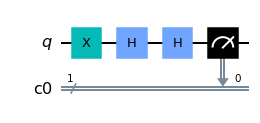

The measurements of the decoy photon at position 0 after the attack is: {'1': 995, '0': 29}


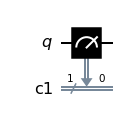

The measurements of the decoy photon at position 1 after the attack is: {'0': 1013, '1': 11}


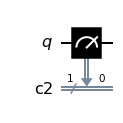

The measurements of the decoy photon at position 2 after the attack is: {'0': 1018, '1': 6}


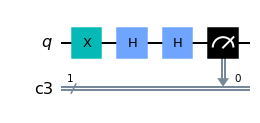

The measurements of the decoy photon at position 3 after the attack is: {'1': 994, '0': 30}


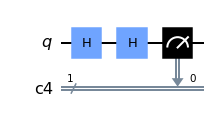

The measurements of the decoy photon at position 5 after the attack is: {'0': 1017, '1': 7}


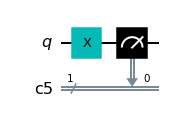

The measurements of the decoy photon at position 14 after the attack is: {'1': 992, '0': 32}


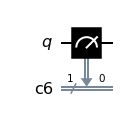

The measurements of the decoy photon at position 17 after the attack is: {'0': 1015, '1': 9}


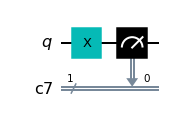

The measurements of the decoy photon at position 20 after the attack is: {'1': 987, '0': 37}


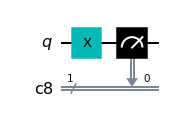

The measurements of the decoy photon at position 21 after the attack is: {'1': 997, '0': 27}


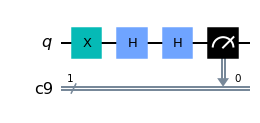

The measurements of the decoy photon at position 23 after the attack is: {'1': 991, '0': 33}
Error rate in measuring decoy photons: 2.158203125 %
The number of mismatched decoy photons is 0 and the error rate of trasmitting decoy photons: 0.0 %
Time taken to measure 10 decoy photons: 0 hours 0 minutes 3.3151378631591797 seconds

No Eavesdropper detected.


In [10]:
#Measuring the decoy photons inserted in sequence of pure entangled states in respective bases and finiding the errors

errors_for_first_check0=[]
errors_count_for_first_check0=[]
def check_eavesdropper1(pkd,rdq_st1,errors_for_first_check0,errors_count_for_first_check0,pos1):
    j=0
    err1=0
    err_rate1=0.0
    err_flag1=0
    err_count1=0
    err_count_rate1=0.0
    time01 = time.time()
    for i in pos1:
        flag=0
        pkd[i].add_register(ClassicalRegister(1))
        if rdq_st1[j]=='+' or rdq_st1[j]=='-':
            pkd[i].h(0)
            flag=1
        pkd[i].measure(0,0)
        rslt1 = execute(pkd[i], backend=created_noisy_sim, shots=shots).result()
        cc1 = rslt1.get_counts()
        k=list(cc1.keys())
        k.sort()
        display(pkd[i].draw('mpl'))
        print("The measurements of the decoy photon at position",i,"after the attack is:",cc1)       
        err1,err_flag1=noisy_meas_err_func(cc1,rdq_st1,j,shots,flag)
        err_count1+=err_flag1
        j=j+1
        err_rate1=err_rate1+float((err1/shots)*100)
    time_1 = time.time() - time01
    hr1 = time_1//3600
    time_1 %= 3600
    err_rate1=float(err_rate1/nd)
    err_count_rate1=float(( err_count1/nd)*100)
    errors_for_first_check0.append(err_rate1)
    errors_count_for_first_check0.append(err_count_rate1)
    return  err_count1,err_count_rate1,err_rate1,hr1,time_1

err_count1,err_count_rate1,err_rate1,hr1,time_1=check_eavesdropper1(pkd0,rdq_st10,errors_for_first_check0,errors_count_for_first_check0,pos10)
print(f"Error rate in measuring decoy photons: {err_rate1} %")
print(f"The number of mismatched decoy photons is {err_count1} and the error rate of trasmitting decoy photons: {err_count_rate1} %")
print(f'Time taken to measure {nd} decoy photons: {int(hr1)} hours {int(time_1//60)} minutes {time_1%60} seconds')
if err_count1!=0:
    print("\nEavesdropper detected.")
else:
    print("\nNo Eavesdropper detected.")

In [11]:
#Step2:Creating a sequence of travelling qubits in Z basis

def create_tq(msg):
    tt=[]
    for i in msg:
        t=QuantumCircuit(QuantumRegister(1))
        if i==0:
            tt.append(t)
        else:
            t.x(0)
            tt.append(t)
    return tt


tq0=create_tq(message)        

In [12]:
#Step3: Encrypting the message using CNOT gate

def encrypt_mes(pk,tt,m):
    for i in range(m):       
        pk[i].add_register(*tt[i].qregs)
        pk[i].barrier()
        pk[i]=pk[i]+tt[i]
        #display(pk[i].draw('mpl'))
        pk[i].cx(0,2)
        

encrypt_mes(private_key0,tq0,n)


#inserting decoy photons in the sequence of travelling photons to check for eavesdropping
def insert_decoys2(private_key,nd):
    rdq_st2=[]
    lst=[x for x in range(n+nd)]
    pos2=sample(lst,nd)
    pos2.sort()
    rdq2=[]
    for i in pos2:
        decoy_st2=choice(states)
        decoy2=gen_decoy(decoy_st2)
        rdq2.append(decoy2)
        rdq_st2.append(decoy_st2)
        decoy22=decoy2.copy()
        private_key.insert(i,decoy22)
    print(pos2)
    return private_key,rdq_st2,pos2

private_key0,rdq_st20,pos20=insert_decoys2(private_key0,nd)

[0, 3, 4, 7, 10, 12, 14, 21, 22, 23]


<ipython-input-12-1da6b4dc2c54>:7: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  pk[i]=pk[i]+tt[i]


In [13]:
for i in range(nd):
    print(rdq_st20[i])

-
-
-
-
0
1
0
-
-
-


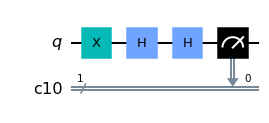

The measurements of the decoy photon at position 0 after the attack is: {'1': 998, '0': 26}


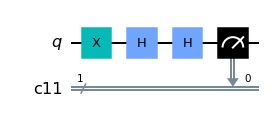

The measurements of the decoy photon at position 3 after the attack is: {'1': 988, '0': 36}


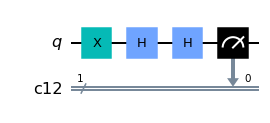

The measurements of the decoy photon at position 4 after the attack is: {'1': 992, '0': 32}


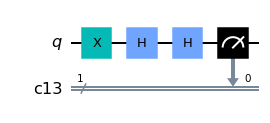

The measurements of the decoy photon at position 7 after the attack is: {'1': 998, '0': 26}


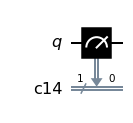

The measurements of the decoy photon at position 10 after the attack is: {'0': 1015, '1': 9}


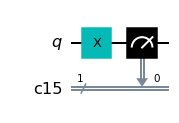

The measurements of the decoy photon at position 12 after the attack is: {'1': 996, '0': 28}


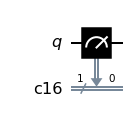

The measurements of the decoy photon at position 14 after the attack is: {'0': 1011, '1': 13}


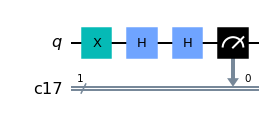

The measurements of the decoy photon at position 21 after the attack is: {'1': 992, '0': 32}


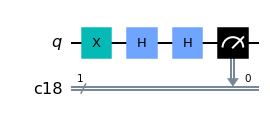

The measurements of the decoy photon at position 22 after the attack is: {'1': 990, '0': 34}


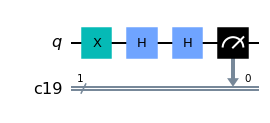

The measurements of the decoy photon at position 23 after the attack is: {'1': 991, '0': 33}
Error rate in measuring decoy photons: 2.626953125 %
The number of mismatched decoy photons is 0 and the error rate of trasmitting decoy photons: 0.0 %
Time taken to measure 10 decoy photons: 0 hours 0 minutes 3.0807645320892334 seconds

No Eavesdropper detected.


In [14]:
#Measuring the decoy photons inserted in sequence of travelling photons in respective bases and finiding the errors

errors_for_second_check0=[]
def check_eavesdropper2(pk,rdq_st2,errors_for_second_check,pos2):
    j=0
    err2=0
    err_rate2=0.0
    err_flag2=0
    err_count2=0
    err_count_rate2=0.0
    time02 = time.time()
    for i in pos2:
        flag=0
        pk[i].add_register(ClassicalRegister(1))
        if rdq_st2[j]=='+' or rdq_st2[j]=='-':
            pk[i].h(0)
            flag=1
        pk[i].measure(0,0)
        rslt2 = execute(pk[i], backend=created_noisy_sim, shots=shots).result()
        cc2 = rslt2.get_counts()
        m=list(cc2.keys())
        m.sort()
        display(pk[i].draw('mpl'))
        print("The measurements of the decoy photon at position",i,"after the attack is:",cc2)       
        err2,err_flag2=noisy_meas_err_func(cc2,rdq_st2,j,shots,flag)
        err_count2+=err_flag2
        j=j+1
        err_rate2=err_rate2+float((err2/shots)*100)
    time_2 = time.time() - time02
    hr2 = time_2//3600
    time_2 %= 3600
    err_rate2=float(err_rate2/nd)
    err_count_rate2=float((err_count2/nd)*100)
    errors_for_second_check.append(err_rate2)
    return err_count2,err_count_rate2,err_rate2,hr2,time_2

err_count2,err_count_rate2,err_rate2,hr2,time_2=check_eavesdropper2(private_key0,rdq_st20,errors_for_second_check0,pos20)
print(f"Error rate in measuring decoy photons: {err_rate2} %")
print(f"The number of mismatched decoy photons is {err_count2} and the error rate of trasmitting decoy photons: {err_count_rate2} %")
print(f'Time taken to measure {nd} decoy photons: {int(hr2)} hours {int(time_2//60)} minutes {time_2%60} seconds')
if err_count2!=0:
    print("\nEavesdropper detected.")
else:
    print("\nNo Eavesdropper detected.")

In [15]:
#Step 4: Decrypting the message using CNOT gate

def decrypt_mes(pk,m,pos2):
    for i in range(m):
        if i not in pos2:
            pk[i].cx(1,2)
            pk[i].barrier()
        
decrypt_mes(private_key0,n+nd,pos20)

In [16]:
def cal_error_and_res(fm,mssg,j):
    error=0
    wrong_mssg=0
    a=list(fm.keys())
    a.sort()
    res=-1
    if '0' in fm and '1' not in fm:
        res=0
    elif '1' in fm and '0' not in fm:
        res=1
    if '0' in fm and '1' in fm:
        if fm['0']>fm['1'] and abs(fm['0']-fm['1'])>600:
            res=0
        elif fm['0']<fm['1'] and abs(fm['0']-fm['1'])>600:
            res=1
        if int(a[0])==mssg[j]:
            error=fm['1']
        elif int(a[1])==mssg[j]:
            error=fm['0']
    if res!=mssg[j]:
        wrong_mssg=1
    return res,error,wrong_mssg

In [17]:
#Measuring the travelling qubit in Z basis

error_lst=[]
errors_in_mssg=[]
def measure_tq(pk,error_lst,errors_in_mssg,mssg,pos2):
    error=0
    error_rate=0.0
    error_in_mssg=0
    error_in_mssg_rate=0.0
    result2=[]
    time03 = time.time()
    j=0
    for i in range(n+nd):
        if i not in pos2:
            pk[i].measure(2,0)
            pk[i].barrier()
            result = execute(pk[i], backend=created_noisy_sim, shots=shots).result()
            noisy_counts=result.get_counts()
            print(noisy_counts)
            res,error,wrong_mssg=cal_error_and_res(noisy_counts,mssg,j)
            error_in_mssg+=wrong_mssg
            error_rate = error_rate + float((error/shots)*100)
            result2.append(res)
            #display(private_key[i].draw('mpl'))
            j+=1
    time_3 = time.time() - time03
    hr3 = time_3//3600
    time_3 %= 3600
    error_in_mssg_rate=float((error_in_mssg/n)*100)
    error_rate = float(error_rate/n)
    error_lst.append(error_rate)
    errors_in_mssg.append(error_in_mssg_rate)
    print(f"The number of mismatched message photons is {error_in_mssg} and the amount of mismatched message photons:{error_in_mssg_rate} %")
    print(f"Error rate in measuring message photons: {error_rate} %")
    print(f'Time taken to measure {n} message photons: {int(hr3)} hours {int(time_3//60)} minutes {time_3%60} seconds')
    return result2

final_res=measure_tq(private_key0,error_lst,errors_in_mssg,message,pos20)     


{'1': 954, '0': 70}
{'0': 1004, '1': 20}
{'0': 1003, '1': 21}
{'0': 993, '1': 31}
{'0': 996, '1': 28}
{'0': 1000, '1': 24}
{'0': 1005, '1': 19}
{'1': 940, '0': 84}
{'0': 1002, '1': 22}
{'0': 1000, '1': 24}
{'0': 1004, '1': 20}
{'1': 944, '0': 80}
{'0': 79, '1': 945}
{'0': 996, '1': 28}
{'0': 995, '1': 29}
The number of mismatched message photons is 0 and the amount of mismatched message photons:0.0 %
Error rate in measuring message photons: 3.76953125 %
Time taken to measure 15 message photons: 0 hours 0 minutes 2.109360456466675 seconds


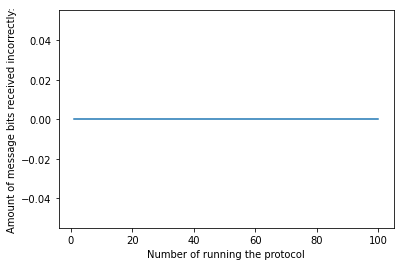

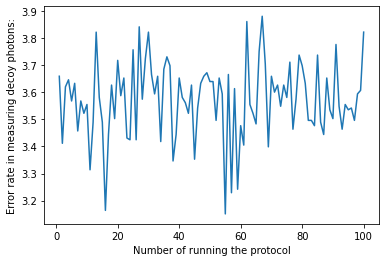

In [20]:
#running the protocol 100 times for the same message to plot graph for varying error rate
error_lst=[]
errors_in_mssg=[]
size=100
for i in range(size):
    private_key=create_pest(n)
    tq=create_tq(message)
    encrypt_mes(private_key,tq,n)
    private_key,rdq_st2,pos2=insert_decoys2(private_key,nd)
    decrypt_mes(private_key,n+nd,pos2)
    final_res=measure_tq(private_key,error_lst,errors_in_mssg,message,pos2)

clear_output()

plt.plot(range(1,size+1),errors_in_mssg)
plt.xlabel('Number of running the protocol')
plt.ylabel('Amount of message bits received incorrectly:')
plt.show()

plt.plot(range(1,size+1),error_lst)
plt.xlabel('Number of running the protocol')
plt.ylabel('Error rate in measuring decoy photons:')
plt.show()